In [5]:
import heist
import helpers
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_impala import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random
import steering_experiments



%load_ext autoreload
%autoreload 2

ordered_layer_names  = {
    1: 'conv1a',
    2: 'pool1',
    3: 'conv2a',
    4: 'conv2b',
    5: 'pool2',
    6: 'conv3a',
    7: 'pool3',
    8: 'conv4a',
    9: 'pool4',
    10: 'fc1',
    11: 'fc2',
    12: 'fc3',
    13: 'value_fc',
    14: 'dropout_conv',
    15: 'dropout_fc'
}


ENTITY_COLORS = {
    "blue": 0,
    "green": 1,
    "red": 2
}

ENTITY_TYPES = {
    "key": 2,
    "lock": 1,
    "gem": 9,
    "player": 0
}



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
venv = steering_experiments.create_corridor_environment(
    entity_one=("key", "blue"),
    entity_two=("key", "green"),
    corridor_length=9
)

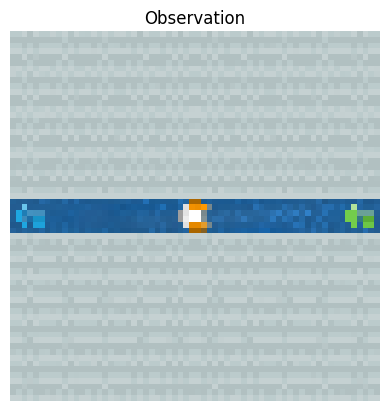

In [33]:
helpers.plot_single_observation(venv.reset())

In [9]:
from steering_experiments import create_corridor_environment


def compare_blue_green_key_collection(model_path, num_episodes=100):
    blue_key_collected = 0
    green_key_collected = 0
    neither_collected = 0

    for episode in range(num_episodes):
        # Create the corridor environment with blue and green keys
        venv = create_corridor_environment(
            entity_one=("key", "blue"),
            entity_two=("key", "green"),
            corridor_length=9
        )

        model = helpers.load_interpretable_model(model_path=model_path)
        
        obs = venv.reset()
        done = False
        steps = 0
        max_steps = 100  # Prevent infinite loops
        
        while not done and steps < max_steps:
            action = model.act(obs)
            obs, reward, done, info = venv.step(action)
            steps += 1
            
            # Check if a key was collected
            if reward > 0:
                # Determine which key was collected based on the remaining entities
                state = heist.state_from_venv(venv)
                remaining_keys = [ent for ent in state.state_vals["ents"] if ent["image_type"].val == ENTITY_TYPES["key"]]
                
                if len(remaining_keys) == 1:
                    if remaining_keys[0]["image_theme"].val == ENTITY_COLORS["blue"]:
                        green_key_collected += 1
                    else:
                        blue_key_collected += 1
                    break
        
        if steps == max_steps:
            neither_collected += 1
        
        venv.close()

    total_collected = blue_key_collected + green_key_collected
    results = {
        "blue_key_collected": blue_key_collected,
        "green_key_collected": green_key_collected,
        "neither_collected": neither_collected,
        "blue_key_percentage": blue_key_collected / total_collected * 100 if total_collected > 0 else 0,
        "green_key_percentage": green_key_collected / total_collected * 100 if total_collected > 0 else 0
    }
    
    return results


model_path = "../model_interpretable.pt"
results = compare_blue_green_key_collection(model_path, num_episodes=100)
print(results)


AttributeError: 'CustomCNN' object has no attribute 'act'

In [11]:
from steering_experiments import run_entity_steering_experiment, run_entity_steering_experiment_by_channel, run_patching_experiment
model_path = "../model_interpretable.pt"
total_episodes = 5
layer_success_counts = {}
patching_objectives = {}

entity = ["key"]
entity_colors = ["green"]

import itertools
import random

all_positions = list(itertools.product(range(8), repeat=2))
patch_positions = random.sample(all_positions, 20)

patch_positions = [(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)]

patch_value = -1.3  
target_channel = 4
layer_number = 8

save_gif = False
for channel in [target_channel]:  # Run channels 0 to 31
    for entity_name in entity:
        for entity_color in entity_colors:
            if entity_name == "gem":
                entity_color = None
            total_reward = 0
            total_steps_until_pickup = 0
            total_count_pickups = 0
            
            for episode, patch_position in enumerate(patch_positions):
                reward, steps, pickups = run_patching_experiment(model_path, layer_number, episode, channel,patch_position, patch_value, entity_name, entity_color, save_gif=save_gif)
                total_reward += reward
                total_steps_until_pickup += steps
                total_count_pickups += pickups
            
            if entity_name == "gem":
                entity_color = ""
            
            key = f"{entity_name}{entity_color}_channel{channel}"
            patching_objectives[key] = {
                'avg_total_reward': total_reward / total_episodes,
                'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                'total_count_pickups': total_count_pickups 
            }


True
Key picked up after 11 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 20 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 20 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 30 steps
Saved gif!
Key picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Key picked up after 45 steps
Saved gif!
Key picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Key picked up after 16 steps
Saved gif!
Key picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Key picked up after 29 steps
Saved gif!
Key picked up during the episode


In [4]:
from steering_experiments import run_entity_steering_experiment, run_entity_steering_experiment_by_channel
model_path = "../model_interpretable.pt"
modification_value = 5
total_episodes = 10
layer_number = 8
layer_success_counts = {}
objectives = {}

entity = ["key"]
entity_colors = ["blue"]
save_gif = True
for channel in range(31):  # Run channels 0 to 31
    for entity_name in entity:
        for entity_color in entity_colors:
            if entity_name == "gem":
                entity_color = None
            total_reward = 0
            total_steps_until_pickup = 0
            total_count_pickups = 0
            
            for episode in range(total_episodes):
                reward, steps, pickups = run_entity_steering_experiment_by_channel(model_path, layer_number, modification_value, episode, channel, entity_name, entity_color, save_gif=save_gif)
                total_reward += reward
                total_steps_until_pickup += steps
                total_count_pickups += pickups
            
            if entity_name == "gem":
                entity_color = ""
            
            key = f"{entity_name}{entity_color}_channel{channel}"
            objectives[key] = {
                'avg_total_reward': total_reward / total_episodes,
                'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                'total_count_pickups': total_count_pickups 
            }


True
Key picked up after 3 steps
Saved gif!
Key picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Key picked up after 3 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 2 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 3 steps
Saved gif!
Key picked up during the episode
True


Exception ignored in: <function PluginV3.__del__ at 0x14646c280>
Traceback (most recent call last):
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/imageio/core/v3_plugin_api.py", line 370, in __del__
    self.close()
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/imageio/plugins/pillow.py", line 144, in close
    self._flush_writer()
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/imageio/plugins/pillow.py", line 485, in _flush_writer
    primary_image.save(self._request.get_file(), **self.save_args)
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/PIL/Image.py", line 2568, in save
    save_handler(self, fp, filename)
  File "/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-

Saved gif!
Key was not picked up during the episode
True
Key picked up after 10 steps
Saved gif!
Key picked up during the episode
True


KeyboardInterrupt: 

In [27]:
objectives

{'keyblue_channel0': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 5.0,
  'total_count_pickups': 10},
 'keyblue_channel1': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 5.2,
  'total_count_pickups': 10},
 'keyblue_channel2': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 5.6,
  'total_count_pickups': 10},
 'keyblue_channel3': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 5.0,
  'total_count_pickups': 10},
 'keyblue_channel4': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 271.8,
  'total_count_pickups': 1},
 'keyblue_channel5': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 5.0,
  'total_count_pickups': 10},
 'keyblue_channel6': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 5.2,
  'total_count_pickups': 10},
 'keyblue_channel7': {'avg_total_reward': array([0.], dtype=float32)

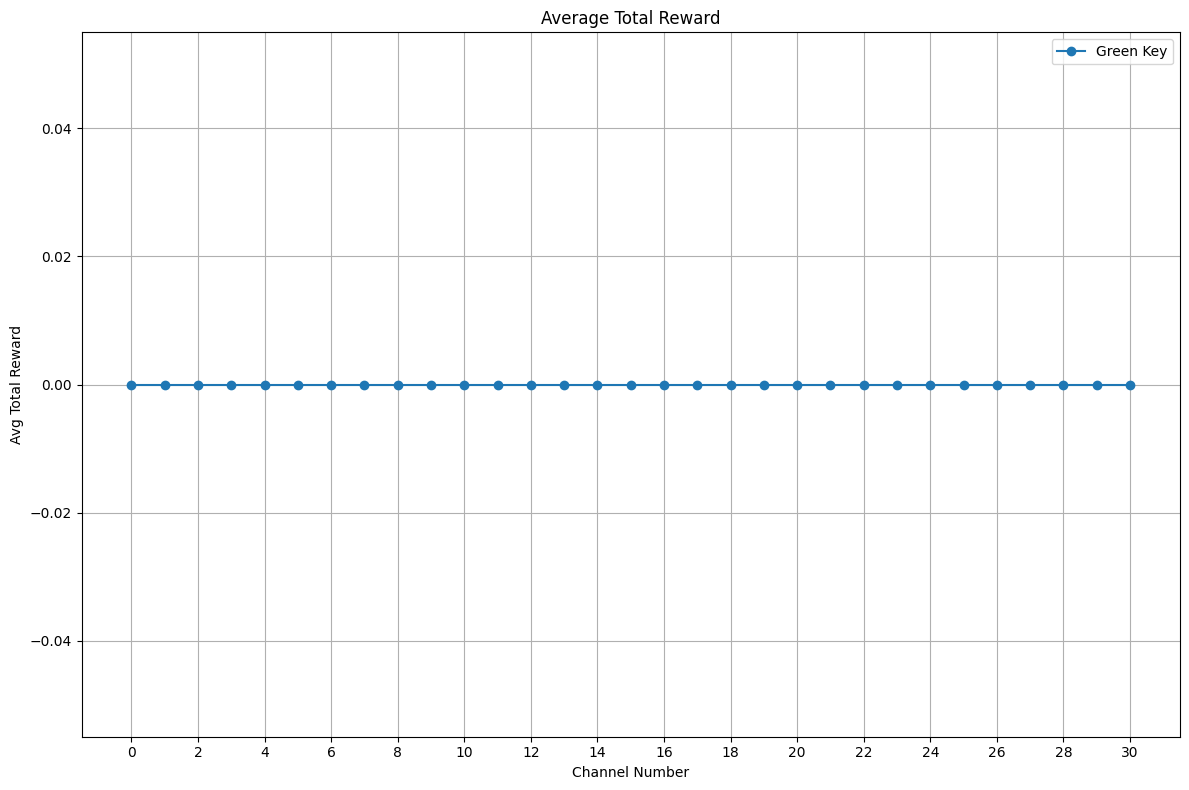

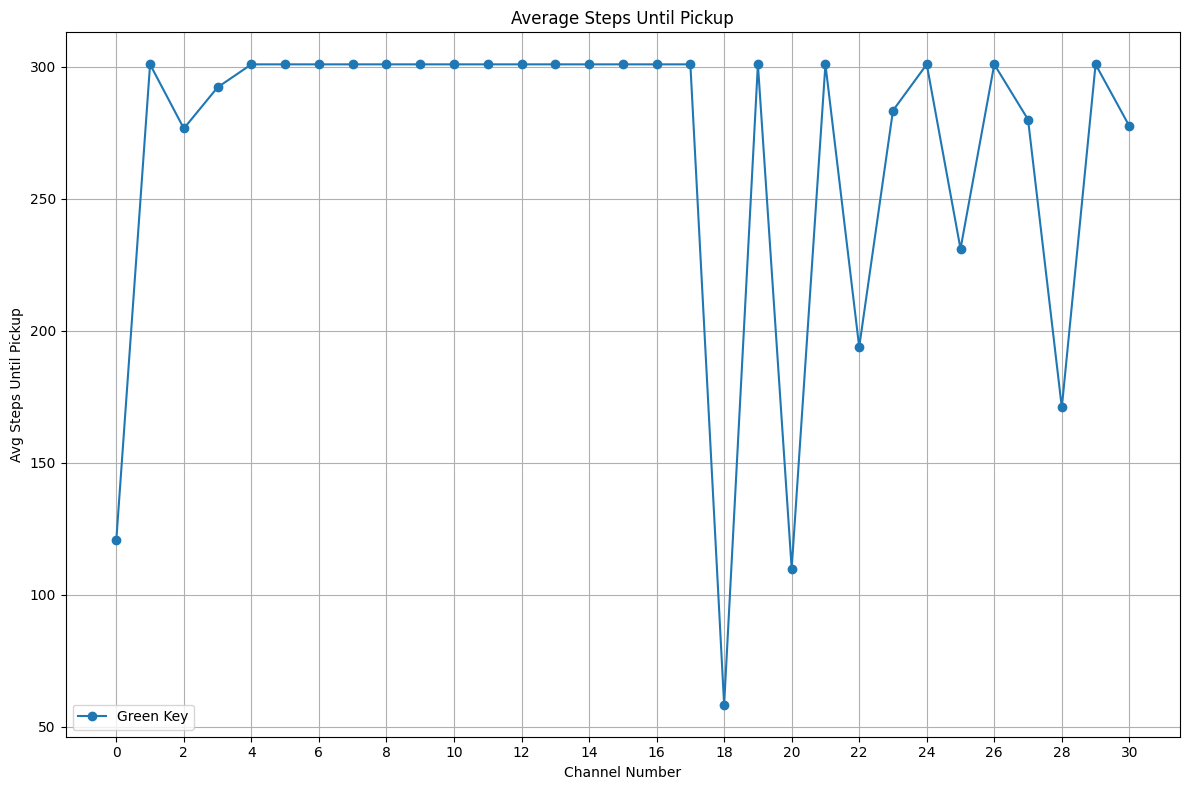

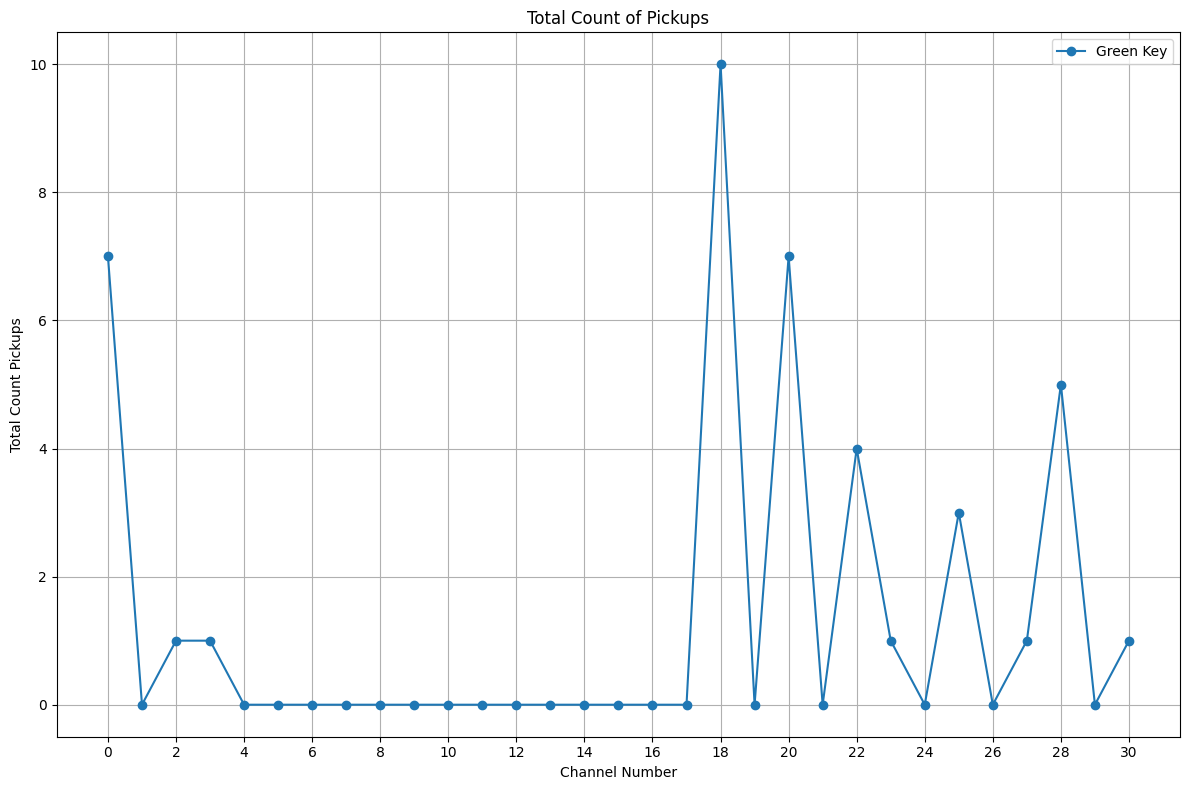

In [32]:
plot_channel_metrics(objectives)

In [11]:
from steering_experiments import run_entity_steering_experiment
import matplotlib.pyplot as plt

model_path = "../model_interpretable.pt"
modification_value = -2
total_episodes = 20
episode = 200
objectives = {}

# entity = ["key", "lock", "gem"]
# entity_colors = ["blue", "red", "green"]
entity = ["key"]
entity_colors = ["green"]
# Define the range of layers to iterate through

layers_to_test = range(1, 14)
for layer_number in layers_to_test:

    count_gem = 0
    objectives[layer_number] = {}
    
    for entity_name in entity:
        if entity_name == "gem":
            if count_gem > 1:
                continue
            count_gem  +=1
            entity_color = None
            total_reward = 0
            total_steps_until_pickup = 0
            total_count_pickups = 0
            
            for _ in range(total_episodes):
                reward, steps, pickups = run_entity_steering_experiment(model_path, layer_number, modification_value, episode, entity_name, entity_color)
                total_reward += reward
                total_steps_until_pickup += steps
                total_count_pickups += pickups
            
            entity_color = ""
            objectives[layer_number][ entity_color + entity_name] = {
                'avg_total_reward': total_reward / total_episodes,
                'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                'total_count_pickups': total_count_pickups 
            }
        else:
            for entity_color in entity_colors:
                total_reward = 0
                total_steps_until_pickup = 0
                total_count_pickups = 0
                
                for _ in range(total_episodes):
                    reward, steps, pickups = run_entity_steering_experiment(model_path, layer_number, modification_value, episode, entity_name, entity_color)
                    total_reward += reward
                    total_steps_until_pickup += steps
                    total_count_pickups += pickups
                
                objectives[layer_number][entity_name + entity_color] = {
                    'avg_total_reward': total_reward / total_episodes,
                    'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                    'total_count_pickups': total_count_pickups 
                }

            
            objectives[layer_number][entity_name + entity_color] = {
                'avg_total_reward': total_reward / total_episodes,
                'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                'total_count_pickups': total_count_pickups 
            }


True
Key was not picked up during the episode
True
Key was not picked up during the episode
True
Key was not picked up during the episode
True


KeyboardInterrupt: 

In [ ]:
import pickle

# Save the objectives object to a pickle file
with open('objectives.pkl', 'wb') as f:
    pickle.dump(objectives, f)


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
layers_to_test = range(1, 14)

# Assuming the experiment has been run and 'objectives' dictionary is populated

metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
entity_combinations = [f"{e}{c}" for e in ["key", "lock"] for c in ["blue", "red", "green"]] + ["gem"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    data = []
    for layer in layers_to_test:
        row = []
        for entity in entity_combinations:
            if entity == "gem":
                value = objectives[layer]["gem"][metric]
            else:
                value = objectives[layer][entity][metric]
            
            # Convert to float if it's a numpy array or other non-float type
            if isinstance(value, np.ndarray):
                value = float(value.item())
            elif not isinstance(value, (int, float)):
                value = float(value)
            
            row.append(value)
        data.append(row)
    
    df = pd.DataFrame(data, columns=entity_combinations, index=list(layers_to_test))
    
    # Rename entities to capture colour and lock or key
    new_entity_names = ['Blue Key', 'Red Key', 'Green Key', 'Blue Lock', 'Red Lock', 'Green Lock', 'Gem']
    df.columns = new_entity_names

    sns.heatmap(df, cmap="YlOrRd", annot=True, fmt=".2f", cbar_kws={'label': metric})
    plt.title(f"Entity Steering Results Across Layers: {metric.replace('_', ' ').title()}")
    plt.xlabel('Entity')
    plt.ylabel('Layer')
    plt.tight_layout()
    plt.show()

KeyError: 1

<Figure size 1000x600 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
titles = ['Average Total Reward', 'Average Steps Until Pickup', 'Total Count of Pickups']
all_entities = ['keyblue', 'keyred', 'keygreen', 'lockblue', 'lockred', 'lockgreen', 'gem']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 8))
    
    for entity in all_entities:
        values = [objectives[layer][entity][metric] for layer in layers_to_test]
        
        # Convert numpy array to float if necessary
        values = [float(v.item()) if isinstance(v, np.ndarray) else float(v) for v in values]
        
        # Create a more readable label
        if entity == 'gem':
            label = 'Gem'
        else:
            entity_type = 'Key' if entity.startswith('key') else 'Lock'
            color = entity[3:] if entity.startswith('key') else entity[4:]
            label = f'{color.capitalize()} {entity_type}'
        
        plt.plot(list(layers_to_test), values, label=label, marker='o')
    
    plt.title(titles[i])
    plt.xlabel('Layer Number')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: If you want to save the plots
    # plt.savefig(f'{metric}_plot.png')
    # plt.close()

KeyError: 1

<Figure size 1200x800 with 0 Axes>

In [56]:
objectives

{'keygreen_channel0': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 65.8,
  'total_count_pickups': 12},
 'keygreen_channel1': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 48.6,
  'total_count_pickups': 12},
 'keygreen_channel2': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 50.0,
  'total_count_pickups': 12},
 'keygreen_channel3': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 85.2,
  'total_count_pickups': 11},
 'keygreen_channel4': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 73.6,
  'total_count_pickups': 12},
 'keygreen_channel5': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 54.2,
  'total_count_pickups': 12},
 'keygreen_channel6': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 55.4,
  'total_count_pickups': 12},
 'keygreen_channel7': {'avg_total_reward': array([0.], 

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_channel_metrics(objectives, channels_to_test=range(31)):
    metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
    titles = ['Average Total Reward', 'Average Steps Until Pickup', 'Total Count of Pickups']
    all_entities = ['keygreen']  # Only 'keygreen' is present in the objectives

    for i, metric in enumerate(metrics):
        plt.figure(figsize=(12, 8))
        
        for entity in all_entities:
            values = []
            for channel in channels_to_test:
                channel_key = f'keygreen_channel{channel}'
                if channel_key in objectives:
                    value = objectives[channel_key][metric]
                    values.append(float(value.item()) if isinstance(value, np.ndarray) else float(value))
                else:
                    values.append(0)  # or np.nan if you prefer to show gaps
            
            # Create a more readable label
            label = f'Green Key'
            
            plt.plot(channels_to_test, values, label=label, marker='o')

        plt.title(titles[i])
        plt.xlabel('Channel Number')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()
        plt.grid(True)
        plt.xticks(range(0, 32, 2))  # Show channel numbers at intervals of 2
        plt.tight_layout()
        plt.show()

        # Optional: If you want to save the plots
        # plt.savefig(f'{metric}_plot.png')
        # plt.close()

# To use the function:
# plot_channel_metrics(objectives)

In [15]:
# Run steering experiment with just a green key and save the gif
import helpers
import heist
from steering_experiments import run_entity_steering_experiment

# Set up experiment parameters
layer_number = 7  # You can adjust this based on previous results
modification_value = -2 # You can adjust this value
episode = 0  # This is just for naming the gif
entity_name = "key"
entity_color = "green"
num_levels = 1
start_level = random.randint(1, 100000)  # Random start level
episode_timeout = 300  # Adjust as needed
save_gif = True

# Run the experiment
total_reward, steps_until_pickup, count_pickups = run_entity_steering_experiment(
    model_path=model_path,
    layer_number=layer_number,
    modification_value=modification_value,
    episode=episode,
    entity_name=entity_name,
    entity_color=entity_color,
    num_levels=num_levels,
    start_level=start_level,
    episode_timeout=episode_timeout,
    save_gif=save_gif
)

print(f"Total reward: {total_reward}")
print(f"Steps until pickup: {steps_until_pickup}")
print(f"Count of pickups: {count_pickups}")

# Display the saved gif
from IPython.display import Image, display
display(Image(filename=f'episode_steering_{episode}.gif'))


True


KeyboardInterrupt: 

KeyError: 1

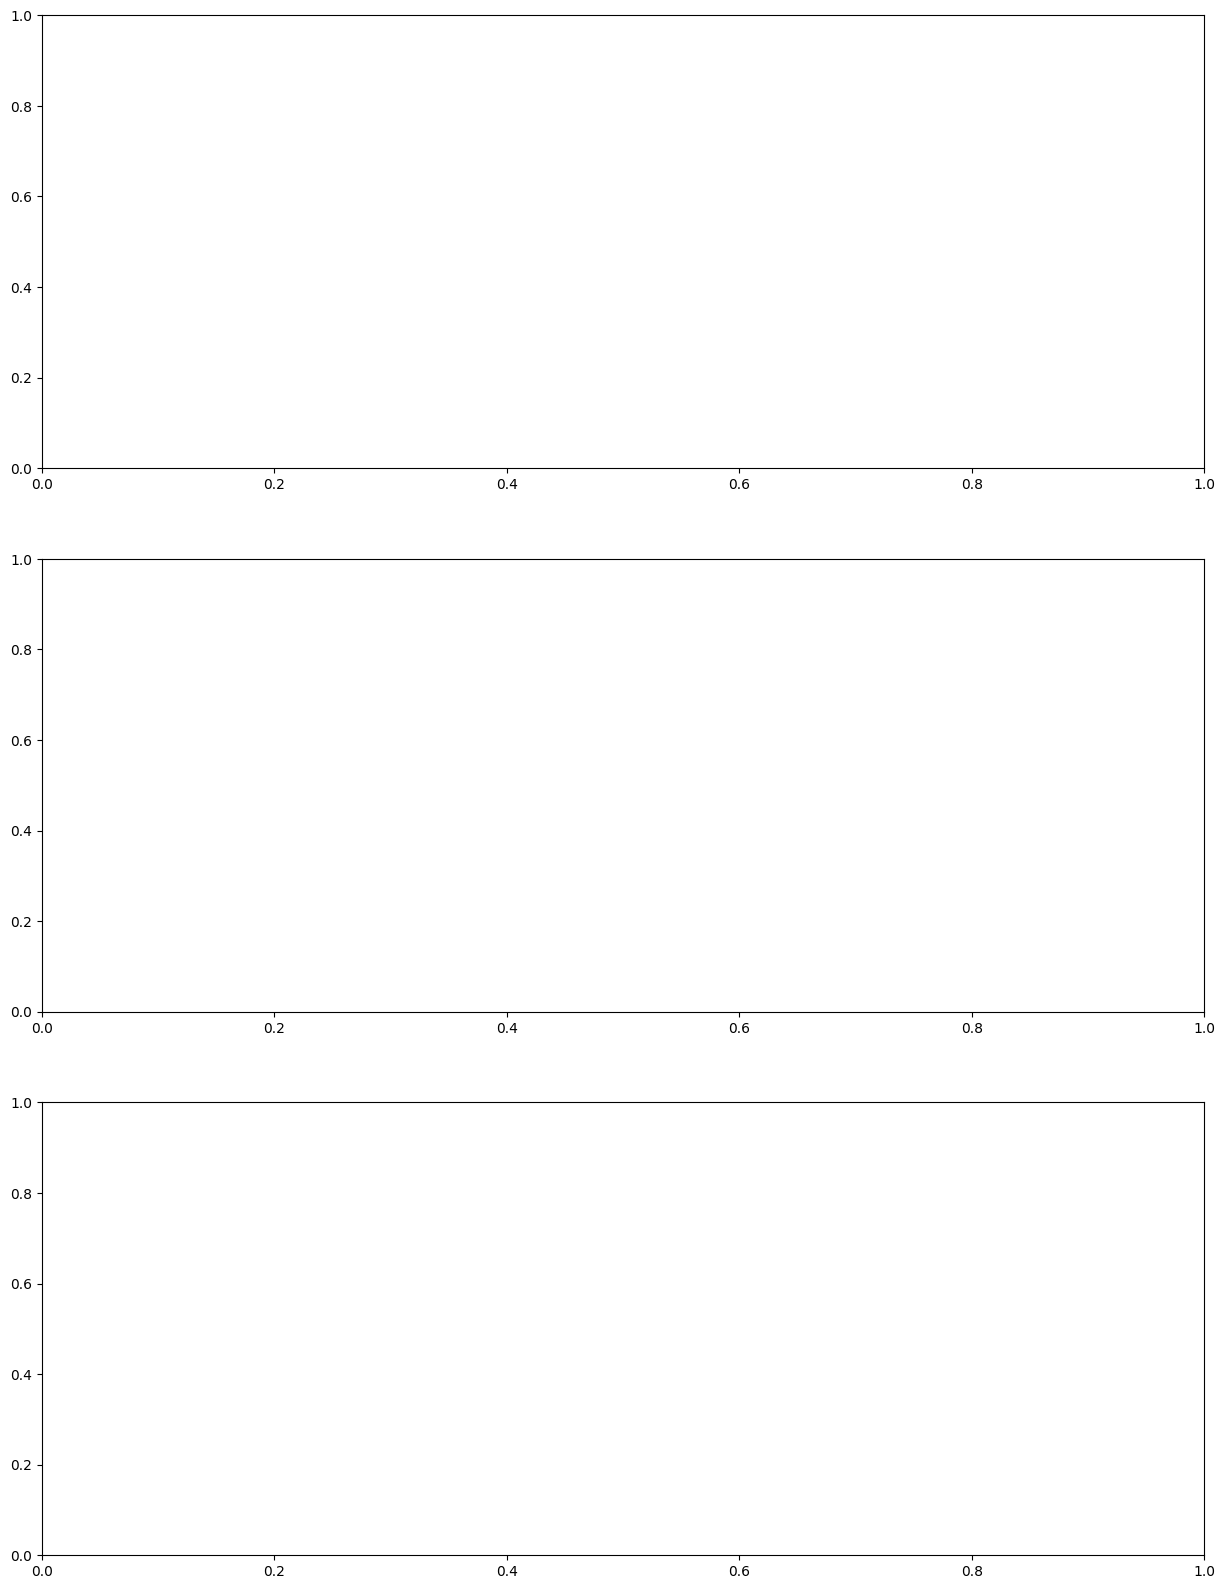

In [52]:
# Plotting the results
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
titles = ['Average Total Reward', 'Average Steps Until Pickup', 'Total Count of Pickups']

for i, metric in enumerate(metrics):
    for entity_name in entity:
        for entity_color in entity_colors:
            if entity_name == "gem":
                entity_color = ""
            label = f"{entity_name}{entity_color}"
            values = [objectives[layer][label][metric] for layer in ordered_layer_names.keys()]
            axs[i].plot(list(ordered_layer_names.keys()), values, label=label)
    
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Layer Number')
    axs[i].set_ylabel(metric.replace('_', ' ').title())
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [5]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()

    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])


    model = helpers.load_interpretable_model(model_path=model_path)
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), [ordered_layer_names[layer_number]])
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), [ordered_layer_names[layer_number]])

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    # helpers.plot_single_observation(observations_steering[-1])
    state = heist.state_from_venv(venv, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)

    return total_reward_steering


model_path = "../model_interpretable.pt"
modification_value = -2
total_episodes = 20
layers_to_test = range(1, 14)  # Layers 1 to 15
layer_success_counts = {}

for layer_number in layers_to_test:
    count_rewards_10 = 0
    for episode in range(total_episodes):
        filepath = f'episode_steering_layer{layer_number}_episode{episode}.gif'
        total_reward_steering = run_gem_steering_experiment(model_path, layer_number, modification_value, episode, save_gif=False)
        if total_reward_steering == 10:
            count_rewards_10 += 1

    
    layer_success_counts[layer_number] = count_rewards_10
    print(f"Layer {layer_number}: Count rewards 10 out of total episodes: {count_rewards_10}/{total_episodes}")

# # Print summary of results
# for layer, count in layer_success_counts.items():
#     print(f"Layer {layer}: {count}/{total_episodes} successes")

# # Find the best performing layer(s)
# max_success = min(layer_success_counts.values())
# best_layers = [layer for layer, count in layer_success_counts.items() if count == max_success]
# print(f"\nBest performing layer(s): {best_layers} with {max_success}/{total_episodes} successes")

    

In [4]:
venv = heist.create_venv(num=1, num_levels=1, start_level=2)
state = heist.state_from_venv(venv, 0)

unchanged_obs = venv.reset()

In [3]:
def run_episode_with_steering_and_check_target_acquisition(env, model, steering_vector, steering_layer, modification_value,filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames=[]
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    print(lock_positions_before)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer,modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)
    
        state = heist.state_from_venv(env, 0)
        

        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break
    
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)
    
    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)
        print(f"Saved gif to {filepath}")
    
    helpers.plot_single_observation(observations[-1])
    
    
    if total_reward == 0: return True

    

    else: return False

In [5]:
model_path = "../model_interpretable.pt"
modification_value = -2
total_episodes = 20
layers_to_test = range(1, 14)  # Layers 1 to 15
layer_success_counts = {}

for layer_number in layers_to_test:
    count_rewards_10 = 0
    for episode in range(total_episodes):
        filepath = f'episode_steering_layer{layer_number}_episode{episode}.gif'
        total_reward_steering = run_episode_with_steering_and_check_target_acquisition(model_path, layer_number, modification_value, save_gif=False)
        if total_reward_steering == 10:
            count_rewards_10 += 1
    
    layer_success_counts[layer_number] = count_rewards_10
    print(f"Layer {layer_number}: Count rewards 10 out of total episodes: {count_rewards_10}/{total_episodes}")

NameError: name 'run_episode_with_steering_and_check_target_acquisition' is not defined